In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
import albumentations
from albumentations.pytorch import ToTensorV2
import pandas as pd
import numpy as np 
import cv2

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# others
import os
from tqdm import tqdm, tqdm_notebook
from sklearn.preprocessing import LabelEncoder
import time

import gc

import warnings as w
w.filterwarnings('ignore')

import sys

from pathlib import Path

sys.path.append('C:/Users/magzu/jupyterLab/iitu/DL/suicide_included')
from src.datasets import SaDataset
from src.models import DepressiiNet

## set CUDA (GPU)

In [2]:
def free_memory_gpu_cpu():
    torch.cuda.empty_cache()
    gc.collect()

if torch.cuda.is_available():
    device = torch.device("cuda")  
else:
    device = torch.device("cpu") 

device

device(type='cuda')

In [3]:
free_memory_gpu_cpu()

# Preprocessing

In [4]:
transform = albumentations.Compose([
   albumentations.Resize(224, 224, p = 1),
   albumentations.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225], p=1),
   albumentations.RandomCrop(224, 224, p=0.5),
   albumentations.RandomBrightnessContrast(),
   ToTensorV2(p=1)
])

test_transform = albumentations.Compose([
   albumentations.Resize(224, 224, p = 1),
   albumentations.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225], p=1),
   ToTensorV2(p=1)
])

In [5]:
train_dir = Path('./data/emotions/train')
test_dir = Path('./data/emotions/test')

train_dataset = SaDataset(train_dir, './emotion_train.csv', transform)
test_dataset = SaDataset(test_dir, './emotion_test.csv', test_transform, train=False)

sns.set_style('white')

Classes and indexes: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}
Length: 120


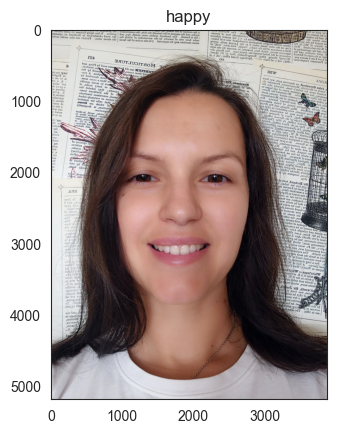

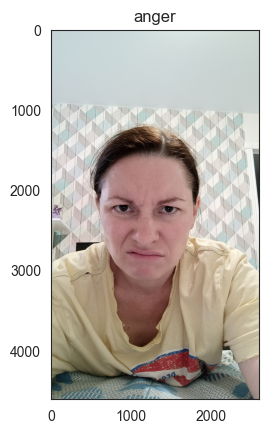

In [16]:
print('Classes and indexes:', train_dataset.class_to_idx)
print('Length:', len(train_dataset))
train_dataset.show_image(60)
train_dataset.show_image(11)

In [17]:
free_memory_gpu_cpu()

In [19]:
batch_size = 14
train_dataloader = DataLoader(train_dataset, shuffle = True, batch_size=batch_size, 
                             num_workers = 1)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, 
                             num_workers = 1)
print(len(train_dataloader))

9


## Building Model

In [20]:
def train_NN(model, dataloader, loss, optimizer, scheduler, n_epochs = 10):
    loss_history = []
    acc_history = []
    
    for epoch in range(n_epochs):
        scheduler.step()
        model.train()
        
        running_loss = 0
        running_acc = 0
        
        for x, y in tqdm(dataloader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
          
            with torch.set_grad_enabled(True):
               
                preds = model(x)
                loss_value = loss(preds, y.long())
                loss_value.backward()
                preds_class = preds.argmax(dim=1)
                optimizer.step()
                
            running_loss += loss_value.item()
            running_acc += (preds_class==y.data).float().mean()
            
        print('Epoch #', epoch+1)
            
        epoch_loss =  running_loss / len(dataloader)
        epoch_acc =  running_acc /  len(dataloader)

        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc.item())
        print('Epoch loss -', epoch_loss)
        print('Epoch accuracy -', epoch_acc.cpu().numpy())
        
    
    return model, loss_history, acc_history

In [24]:
model = DepressiiNet().to(device)

loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model, loss_his, acc_his = train_NN(model, train_dataloader, loss, optimizer, 
                                               scheduler=scheduler, n_epochs=20)

100%|██████████| 9/9 [00:27<00:00,  3.10s/it]


Epoch # 1
Epoch loss - 19.81753902965122
Epoch accuracy - 0.071428575


100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


Epoch # 2
Epoch loss - 12.860298103756374
Epoch accuracy - 0.34523812


100%|██████████| 9/9 [00:31<00:00,  3.49s/it]


Epoch # 3
Epoch loss - 5.468651784790887
Epoch accuracy - 0.42063493


100%|██████████| 9/9 [00:26<00:00,  3.00s/it]


Epoch # 4
Epoch loss - 3.3423992925220065
Epoch accuracy - 0.47817463


100%|██████████| 9/9 [00:27<00:00,  3.02s/it]


Epoch # 5
Epoch loss - 2.438400281800164
Epoch accuracy - 0.5138889


100%|██████████| 9/9 [00:27<00:00,  3.02s/it]


Epoch # 6
Epoch loss - 1.9629063937399123
Epoch accuracy - 0.52579373


100%|██████████| 9/9 [00:27<00:00,  3.02s/it]


Epoch # 7
Epoch loss - 1.964769893222385
Epoch accuracy - 0.59523815


100%|██████████| 9/9 [00:28<00:00,  3.15s/it]


Epoch # 8
Epoch loss - 1.2983091738488939
Epoch accuracy - 0.5952381


100%|██████████| 9/9 [00:27<00:00,  3.04s/it]


Epoch # 9
Epoch loss - 1.1347792148590088
Epoch accuracy - 0.640873


100%|██████████| 9/9 [00:27<00:00,  3.05s/it]


Epoch # 10
Epoch loss - 1.2809128099017673
Epoch accuracy - 0.6170636


100%|██████████| 9/9 [00:26<00:00,  2.99s/it]


Epoch # 11
Epoch loss - 1.0683129760954115
Epoch accuracy - 0.5992063


100%|██████████| 9/9 [00:26<00:00,  2.97s/it]


Epoch # 12
Epoch loss - 0.9313692053159078
Epoch accuracy - 0.74404764


100%|██████████| 9/9 [00:27<00:00,  3.05s/it]


Epoch # 13
Epoch loss - 1.6365060011545818
Epoch accuracy - 0.6130953


100%|██████████| 9/9 [00:27<00:00,  3.05s/it]


Epoch # 14
Epoch loss - 0.831555618180169
Epoch accuracy - 0.70039684


100%|██████████| 9/9 [00:27<00:00,  3.03s/it]


Epoch # 15
Epoch loss - 0.982735448413425
Epoch accuracy - 0.6408731


100%|██████████| 9/9 [00:27<00:00,  3.02s/it]


Epoch # 16
Epoch loss - 1.0096863971816168
Epoch accuracy - 0.6587302


100%|██████████| 9/9 [00:27<00:00,  3.01s/it]


Epoch # 17
Epoch loss - 1.1775653560956318
Epoch accuracy - 0.6408731


100%|██████████| 9/9 [00:27<00:00,  3.11s/it]


Epoch # 18
Epoch loss - 0.9074394504229227
Epoch accuracy - 0.66468257


100%|██████████| 9/9 [00:27<00:00,  3.01s/it]


Epoch # 19
Epoch loss - 0.8855150871806674
Epoch accuracy - 0.6527778


100%|██████████| 9/9 [00:26<00:00,  3.00s/it]

Epoch # 20
Epoch loss - 0.9787292381127676
Epoch accuracy - 0.6170635


In [36]:
free_memory_gpu_cpu()

Text(0, 0.5, 'loss')

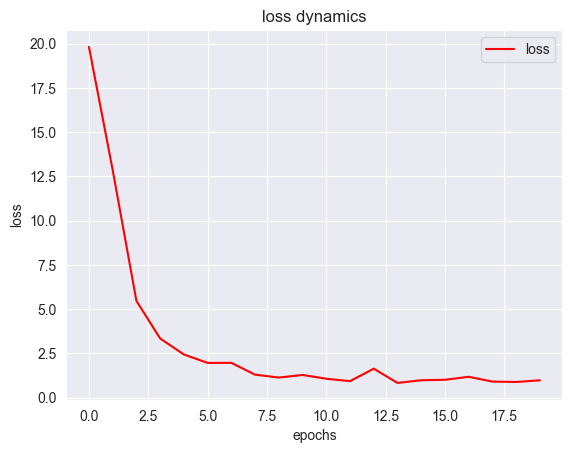

In [26]:
sns.set_style('darkgrid')
sns.lineplot(y=loss_his, x=range(len(loss_his)), color='r', label='loss')
plt.title('loss dynamics')
plt.xlabel('epochs')
plt.ylabel('loss')

Text(0.5, 1.0, 'accuracy dynamics')

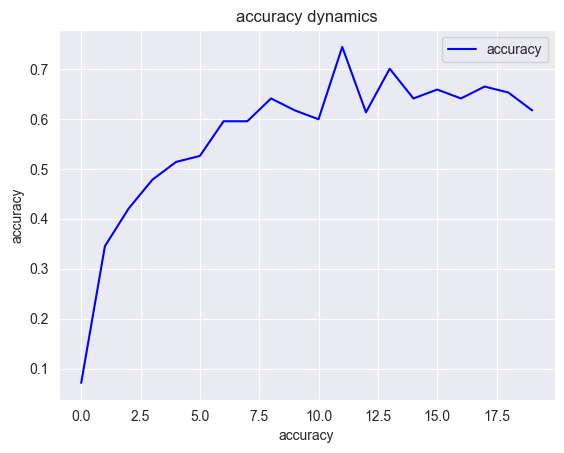

In [27]:
sns.set_style('darkgrid')
sns.lineplot(y=acc_his, x=range(len(acc_his)), color='b', label='accuracy')
plt.xlabel('accuracy')
plt.ylabel('accuracy')
plt.title('accuracy dynamics')

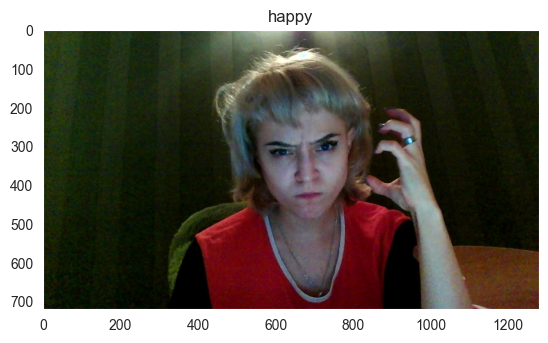

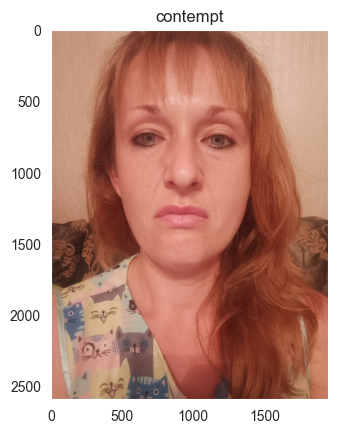

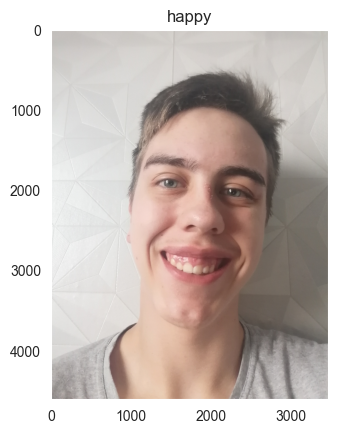

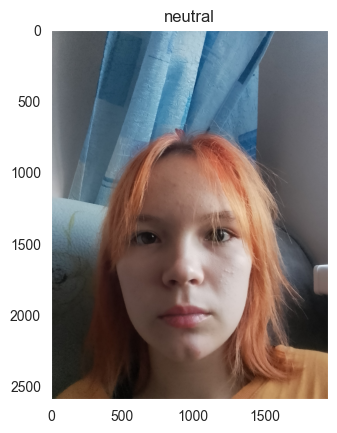

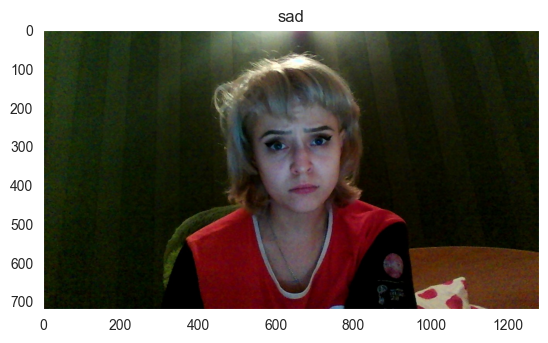

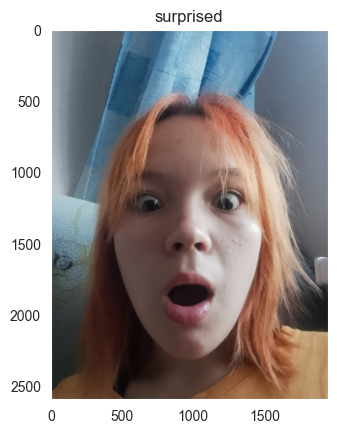

In [32]:
model.eval()
inputs = next(iter(test_dataloader))
inputs = inputs.to(device)
test_predictions= torch.nn.functional.softmax(model(inputs)).argmax(dim = 1)

dct = {value: key for key,value in train_dataset.class_to_idx.items()}

sns.set_style('dark')
for img in range(len(test_predictions)):
    test_dataset.show_image(img, label=dct[test_predictions[img].item()])

# Conclusion:

## 5/6 photos are predicted correct